In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.models import load_model
from imblearn.over_sampling import SMOTE
from keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D,Flatten

### Basic Artificial Neural Network 

* To begin we will go over the basic Artifical Neural Network 
* First we need to preprocess the data, keras can only take numerical inputs
* Second we will train the neural network using the keras archetecture 
* Third we will use the neural network to predict the output and evaluate 

In [2]:
#Read in the data
df_car=pd.read_csv('Data/car.csv',header=None)

In [3]:
#Establish data columns
df_car.columns=['buying','maint','doors','persons','lug_boot','safety','value']

In [4]:
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,value
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


All columns are nominal (categorical ordered) so a label encder will be most appropriate

<AxesSubplot:xlabel='value'>

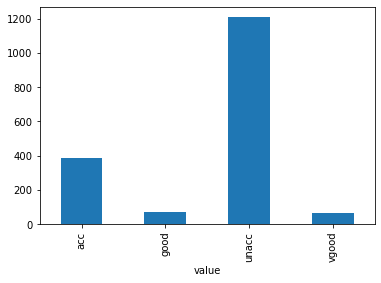

In [5]:
# plotting the output variable 
df_car.groupby('value').count()['buying'].plot(kind='bar')

From this, the good and very good are quite low, so we will turn this problem into a binary acceptable or not acceptable to make model predictions more accurate (this decision will heavily depends on the problem given by the client)

In [6]:
#binarizing the output variable 
binary_out=[]
for i in df_car['value']:
    #if unacceptable append 1
    if i =='unacc':
        binary_out.append(1)
    #else append 0
    else:
        binary_out.append(0)
#replace the column with the binary variable 
df_car['value']=binary_out

In [7]:
#label encode the features
for i in df_car.columns:
    #instantiate new label encoder
    le=LabelEncoder()
    #replace column with encoded data
    df_car[i]=le.fit_transform(df_car[i])
    
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,value
0,3,3,0,0,2,1,1
1,3,3,0,0,2,2,1
2,3,3,0,0,2,0,1
3,3,3,0,0,1,1,1
4,3,3,0,0,1,2,1


In [8]:
#split the input and output variables 
X=df_car.drop('value',axis=1)
y=df_car['value']
#split the data into modeling and validation sets
model_X,valid_X,model_y,valid_y = train_test_split(X,y,test_size=0.2)
#split the modeling set into training and testing sets
train_X,test_X,train_y,test_y=train_test_split(model_X,model_y,test_size=0.2)

Now we can finally create the model, first we establish the input layer, moving to the dense layer and then adding the output layer.
* The input layer includes the of the given input and the relu activation fucnton
* The hidden layer contains the number of units and the desired activation relu function
* the Output layer contains one neuron with an activation fucntion of sigmoid to create the final output
* This will produce a probability that can be interpreted as one or the other completeing the forword propogation 
* To compile the network, we establish which loss function we would like to use along with the optimizer we need, we are establishing how we want the neural network to back propgate
* the final step is to fit the data, and establish the batch size and number of epochs to train over

In [9]:

ann_model=Sequential()
ann_model.add(Dense(20,input_shape=(6,),activation='relu'))
ann_model.add(Dense(10,activation='relu'))
ann_model.add(Dense(1,activation='sigmoid'))

ann_model.compile(loss='binary_crossentropy',optimizer='adam')
ann_model.fit(train_X,train_y,epochs=100,batch_size=100)

Epoch 1/100
12/12 [==============================] - 1s 1ms/step - loss: 0.6594
Epoch 2/100
12/12 [==============================] - 0s 1ms/step - loss: 0.6179
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5957
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5792
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5684
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5594
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5510
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5420
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5335
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5252
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5175
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 0.5101
Epoch 13/100
12/12 [=================

Finally, we make predictions, interpret them, and find the accuracy

In [10]:
predictions_ann=ann_model.predict(test_X)

9/9 [==============================] - 0s 1ms/step


In [11]:
#function that takes in the predictions and produces a decision
def get_nn_preds(predictions):
    prediction_values=[]
    for i in predictions:
        #if the prob is less than 0.5 the append 0
        if i<0.5:
            prediction_values.append(0)
        #if the probability is greater than 0.5 then append 1
        else:
            prediction_values.append(1)
    return prediction_values
        

In [12]:
#get training accuracy 
from sklearn.metrics import accuracy_score
#get decsions 
prediction_values=get_nn_preds(predictions_ann)
#get accuracy 
accuracy_score(prediction_values,test_y)

0.9205776173285198

In [13]:
#get validation accuracy 
#get probability 
predictions_ann_val=ann_model.predict(valid_X)
#get decsions 
prediction_ann_val=get_nn_preds(predictions_ann_val)
#get accuracy 
accuracy_score(prediction_ann_val,valid_y)

11/11 [==============================] - 0s 1ms/step


0.884393063583815

In [14]:
#save the model
ann_model.save('Models/nn_model.sav')

INFO:tensorflow:Assets written to: Models/nn_model.sav\assets


In [15]:
#example model loading for dash 
model=load_model('Models/nn_model.sav')

Let's look at a multi output example 
* In this example we will use all versions of the value field 
* We will need to oversample these values to match the other fields 
* We will then update the neural network archetecture accrodingly

In [16]:
# reread in the data
df_car=pd.read_csv('Data/car.csv',header=None)

In [17]:
#Re-enter in the columns
df_car.columns=['buying','maint','doors','persons','lug_boot','safety','value']

In [18]:
#label encode the features
for i in df_car.columns:
    #instantiate new label encoder
    le=LabelEncoder()
    #replace column with encoded data
    df_car[i]=le.fit_transform(df_car[i])    
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,value
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [82]:
#Since some of our values are undersampled, we'll use an oversampling algorithm to compensate
oversample = SMOTE()
X, y= oversample.fit_resample(df_car.drop('value',axis=1), df_car['value'])

In [86]:
#our outcomes are the same size 
X['y']=y
X.groupby('y').count()['buying']

y
0    1210
1    1210
2    1210
3    1210
Name: buying, dtype: int64

In [20]:
#let's get the predictions
def get_multi_preds(preds):
    predictions=[]
    for i in preds:
        #argmax selects the index with the highest number
        predictions.append(np.argmax(i))
    return predictions

In [21]:
#split the input and output variables 
X=X.drop('y',axis=1)
y=pd.get_dummies(y)
#split the data into modeling and validation sets
model_X,valid_X,model_y,valid_y = train_test_split(X,y,test_size=0.2)
#split the modeling set into training and testing sets
train_X,test_X,train_y,test_y=train_test_split(model_X,model_y,test_size=0.2)

Now let's take a look at the model archetecture 

In [22]:
ann_model=Sequential()
ann_model.add(Dense(20,input_shape=(6,),activation='relu'))
ann_model.add(Dense(10,activation='relu'))
ann_model.add(Dense(4,activation='softmax'))

ann_model.compile(loss='binary_crossentropy',optimizer='adam')
ann_model.fit(train_X,train_y,epochs=100,batch_size=100)

Epoch 1/100
31/31 [==============================] - 1s 1ms/step - loss: 0.6562
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 0.5827
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 0.5545
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 0.5338
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 0.5147
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4959
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4779
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4610
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4457
Epoch 10/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4192
Epoch 12/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4074
Epoch 13/100
31/31 [=================

In [23]:
#Recreate the predictions from the testing set
predictions_ann=ann_model.predict(test_X)

25/25 [==============================] - 0s 903us/step


In [24]:
#get decsions 
prediction_values=get_multi_preds(predictions_ann)
test_y=get_multi_preds(test_y.values)
#get accuracy 
accuracy_score(prediction_values,test_y)

0.9664516129032258

In [25]:
#get validation accuracy 
#get probability 
predictions_ann_val=ann_model.predict(valid_X)
#get decsions 
prediction_ann_val=get_multi_preds(predictions_ann_val)
valid_y=get_multi_preds(valid_y.values)
#get accuracy 
accuracy_score(prediction_ann_val,valid_y)

31/31 [==============================] - 0s 1ms/step


0.9710743801652892

### Long-term Short Memory Neural Network 

Let's get into the LSTM, we need to first take a look at the data

In [26]:
#Read in the training and testing set
climate_df_train=pd.read_csv('Data/climate_time_series/DailyDelhiClimateTrain.csv')
climate_df_test=pd.read_csv('Data/climate_time_series/DailyDelhiClimateTest.csv')

In [27]:
#convert date columns to datetime 
climate_df_train['date']=[pd.to_datetime(i) for i in climate_df_train['date']]
climate_df_test['date']=[pd.to_datetime(i) for i in climate_df_test['date']]

In [28]:
def normalize(df):
    mms=MinMaxScaler()
    df_nd=df.drop('date',axis=1)
    df_norm=pd.DataFrame(mms.fit_transform(df_nd))
    df_norm.columns=df_nd.columns
    df_norm['date']=df['date']
    return df_norm

In [29]:
climate_df_train=normalize(climate_df_train)
climate_df_test=normalize(climate_df_test)

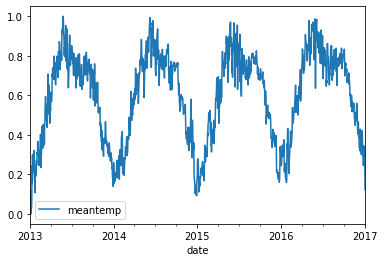

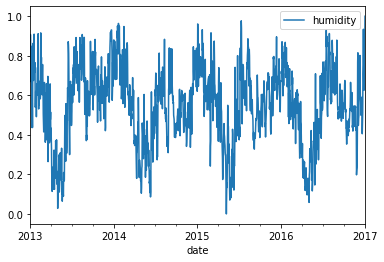

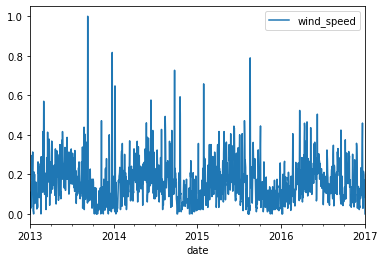

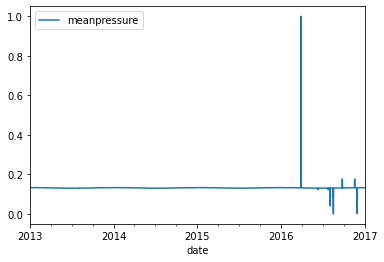

In [30]:
#plot each variable 
for i in climate_df_train.columns:
    if i != 'date':
        climate_df_train.plot(x='date',y=i,kind='line')

Each of these series look normal, however the mean pressure may ruin the model since each time series will affect the prediction of the other

In [31]:
#Let's take a look at the mean pressure statistics
climate_df_train['meanpressure'].describe()

count    1462.000000
mean        0.132009
std         0.023460
min         0.000000
25%         0.130770
50%         0.131679
75%         0.132509
max         1.000000
Name: meanpressure, dtype: float64

In [32]:
#Let's drop the mean pressure for the integrity of the model
climate_df_train.drop('meanpressure',axis=1,inplace=True)
climate_df_test.drop('meanpressure',axis=1,inplace=True)

We now need to confirm that we have data for each data
* This data spans from January 1st 2013 to April 24th 2017
* Training set has 1462 unique dates, testing set has 114 unique dates with January 1st 2017 as the repeated cutoff date
* With 1575 total days between the dates and 1576 calculated days, we have data for each day, so this set can be used without further aggregation 

In [33]:
#1575 is the total number of days
len(climate_df_train)

1462

In [34]:
len(climate_df_test)

114

Now Let's get into the data preprocessing for teh LSTM
* We will make a time series input of a certain number of steps 
* The output will be the next step in the series
* We will predict multiple time series at the same time

In [35]:
#The date will be used as the index
climate_df_train.set_index('date',inplace=True)
climate_df_test.set_index('date',inplace=True)

In [36]:
#this is the function that will create the inputs and putputs for the model to train on 
def preprocess_time(data,steps):
    #establish empty lists
    X=[]
    y=[]
    #Start the for loop
    for i,j in enumerate(data.index):
        #ensure we stop at steps +2 to ensure we don't go over, 1 to account for the output, 1 to account for the 0 index
        if i<=len(data.index)-(steps+2):
            #append the first three steps to X
            X.append(data.iloc[i:i+steps].values)
            #append the next step to y
            y.append(data.iloc[i+steps+1].values)
    #Convert these to arrays for the input
    X_time=np.array(X)
    y_time=np.array(y)
    return X_time,y_time

In [37]:
#establish steps and run the fucntion
n_steps=3
X_train_time,y_train_time=preprocess_time(climate_df_train,n_steps)

In [38]:
y_train_time.shape

(1458, 3)

In [39]:
y_train_time

array([[0.        , 0.84790979, 0.08763619],
       [0.03056769, 0.80132013, 0.03505448],
       [0.03056769, 0.75280528, 0.14921838],
       ...,
       [0.24745269, 0.88063806, 0.14842886],
       [0.276718  , 0.84983498, 0.17349597],
       [0.12227074, 1.        , 0.        ]])

In [40]:
X_train_time.shape

(1458, 3, 3)

Now we are going to create the long term short memory neural network 
* First establish the number of features
* Within the LSTM the input layer is similar to the vanlilla ANN, the difference is, we add n_steps as a new dimension for the input
* Similar to the previous Neural network the outputs are passed to a hidden and output layer with the same number of neurons as the input features 
* We define how we want our model to perform back propogation
* Then we execute the training 

In [41]:
n_features=len(climate_df_train.columns)
model_lstm=Sequential()
model_lstm.add(LSTM(100,input_shape=(n_steps,n_features),activation='relu'))
model_lstm.add(Dense(50,activation='relu'))
model_lstm.add(Dense(n_features))

model_lstm.compile(loss='mse',optimizer='adam')
model_lstm.fit(X_train_time,y_train_time,epochs=100)

Epoch 1/100
46/46 [==============================] - 2s 3ms/step - loss: 0.1132
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 13/100
46/46 [=================

Now let's make some predictions, we start by preprocessing the testing set the same way we preprocess the training features, make the predictions, and evaluate 

In [42]:
#preprocess the testing set
X_test_time,y_test_time=preprocess_time(climate_df_test,n_steps)

In [43]:
X_test_time.shape

(110, 3, 3)

In [44]:
#Make predictions based on the testing set
time_predictions=model_lstm.predict(X_test_time)

4/4 [==============================] - 0s 2ms/step


In [45]:
time_predictions

array([[ 0.27217388,  0.7279004 ,  0.1394657 ],
       [ 0.31141135,  0.62350494,  0.1473504 ],
       [ 0.32116   ,  0.68259   ,  0.1439683 ],
       [ 0.32659134,  0.6524522 ,  0.15962246],
       [ 0.2119486 ,  0.7035525 ,  0.12954946],
       [ 0.19988918,  0.65156996,  0.12552904],
       [ 0.16351482,  0.6950629 ,  0.12694564],
       [ 0.12386993,  0.6239759 ,  0.10149582],
       [ 0.07369322,  0.61869895,  0.08215276],
       [ 0.07473074,  0.6520574 ,  0.07112688],
       [ 0.10331153,  0.6488502 ,  0.09133457],
       [ 0.13392082,  0.67205584,  0.11244095],
       [ 0.20250544,  0.68630725,  0.13802616],
       [ 0.18789211,  0.6943854 ,  0.1418138 ],
       [ 0.1185445 ,  0.6560075 ,  0.09544599],
       [ 0.09282541,  0.6575885 ,  0.08438118],
       [ 0.12814808,  0.68337834,  0.11111306],
       [ 0.16091642,  0.6561851 ,  0.10405699],
       [ 0.14841324,  0.6689799 ,  0.06191281],
       [ 0.22622949,  0.7119458 ,  0.07145602],
       [ 0.25915134,  0.700148  ,  0.098

In [46]:
y_test_time

array([[0.3144208 , 0.73247954, 0.10668393],
       [0.35396518, 0.78849326, 0.40689493],
       [0.15780142, 1.        , 0.48275061],
       [0.19932811, 0.84238611, 0.03137763],
       [0.15197568, 0.80759262, 0.28757844],
       [0.04728132, 0.69405905, 0.44478755],
       [0.        , 0.69619353, 0.46772034],
       [0.03359462, 0.72779869, 0.29223397],
       [0.0951189 , 0.63148974, 0.28157832],
       [0.09361702, 0.72397012, 0.21691005],
       [0.23126735, 0.70200919, 0.12511639],
       [0.15531915, 0.7773746 , 0.50162367],
       [0.03073286, 0.85414443, 0.37103076],
       [0.08687943, 0.77588047, 0.25892353],
       [0.15400203, 0.73502058, 0.49928612],
       [0.18141097, 0.62399596, 0.54883323],
       [0.18686401, 0.68029326, 0.68657886],
       [0.31659574, 0.7490715 , 0.24993326],
       [0.3028786 , 0.74599787, 0.29929745],
       [0.31267345, 0.64521368, 0.11177711],
       [0.42553191, 0.66864461, 0.41103297],
       [0.22036474, 0.94633328, 0.39495966],
       [0.

In [48]:
#Evaluate predictions 
mean_squared_error(time_predictions,y_test_time)

0.041400417492063406

In [49]:
#create the dataframes for predictions and validations 
preds=pd.DataFrame(time_predictions)
preds.columns=climate_df_test.columns
valid=pd.DataFrame(y_test_time)
valid.columns=climate_df_test.columns

In [50]:
#get dates
dates=climate_df_test.iloc[0:len(climate_df_test)-4].index
dates_e=[pd.to_datetime(i) for i in dates]

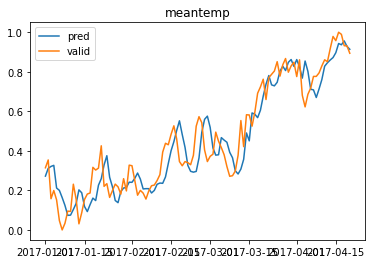

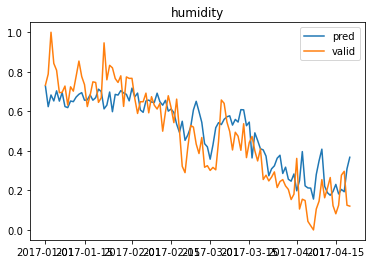

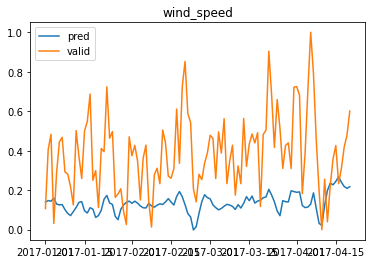

In [51]:
import matplotlib.pyplot as plt
#plot each of the columns against their predictions 
for i in preds.columns:
    #emplty plot
    fig,ax1=plt.subplots(1)
    #plot lines
    ax1.plot(dates_e,preds[i],label='pred')
    ax1.plot(dates_e,valid[i],label='valid')
    #put in title and legend
    plt.title(i)
    plt.legend()

Let's get a bit easier, and demonstrate how to make asingle input LSTM model
* We will now recreate the previous steps with a single input neural network 
* We will use the same functions, but different inputs
* The neural network will be modified accordingly 

In [52]:
#establish steps and run the fucntion
n_steps=3
X_train_time,y_train_time=preprocess_time(climate_df_train.drop(['humidity','wind_speed'],axis=1),n_steps)

In [53]:
X_train_time.shape

(1458, 3, 1)

Now let's train the single LSTM neural Network 

In [54]:
n_features=1
model_lstm=Sequential()
model_lstm.add(LSTM(100,input_shape=(n_steps,n_features),activation='relu'))
model_lstm.add(Dense(50,activation='relu'))
model_lstm.add(Dense(n_features))

model_lstm.compile(loss='mse',optimizer='adam')
model_lstm.fit(X_train_time,y_train_time,epochs=100)

Epoch 1/100
46/46 [==============================] - 2s 3ms/step - loss: 0.1332
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 13/100
46/46 [=================

In [55]:
#preprocess new testing set
X_test_time,y_test_time=preprocess_time(climate_df_test.drop(['humidity','wind_speed'],axis=1),n_steps)

In [56]:
X_test_time.shape

(110, 3, 1)

In [57]:
#Make predictions based on the testing set
time_predictions=model_lstm.predict(X_test_time)

4/4 [==============================] - 0s 2ms/step


In [58]:
#Evaluate
mean_squared_error(time_predictions,y_test_time)

0.008955467450345245

In [59]:
#get dates
dates=climate_df_test.iloc[0:len(climate_df_test)-4].index
dates_e=[pd.to_datetime(i) for i in dates]

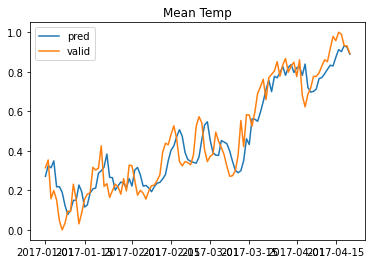

In [60]:
#emplty plot
fig,ax1=plt.subplots(1)
#plot lines
ax1.plot(dates_e,time_predictions,label='pred')
ax1.plot(dates_e,valid['meantemp'],label='valid')
#put in title and legend
plt.title('Mean Temp')
plt.legend()

### Convolutional Neural Network 

Convolutional Neural Networks require a more creative set up compared to the previous models 
* We need to read in the images
* Preprocess the images
* Label the images
* Give them proper input data types 
* Train the Convolutional Neural Network
* Evaluate the mdoel 

Let's start by reading in the images and labeling them
* Read in the directories of the cat and dog images
* Read in the directories of both the training and testing set
* Crete the comprehensive list of full directories 
* Reshape images, normalize, and append them to a list along with a label
* Reshape arrays to make it a proper input for the neural network 

In [62]:
#Establish first part of directory
cat_dir_train='Data/dog_cat_data/training_set/training_set/cats'
dog_dir_train='Data/dog_cat_data/training_set/training_set/dogs'
#Read in list of directories 
cat_train=os.listdir(cat_dir_train)
dog_train=os.listdir(dog_dir_train)

In [63]:
#Establish first part of directory
cat_dir_test='Data/dog_cat_data/test_set/test_set/cats'
dog_dir_test='Data/dog_cat_data/test_set/test_set/dogs'
#Read in list of directories 
cat_test=os.listdir(cat_dir_test)
dog_test=os.listdir(dog_dir_test)

In [64]:
#Let's aggregate the directories
def get_full_dirs(dir_list,dir_start):
    #Empty list
    full_dir_list=[]
    #Iterate through the directory list
    for i in dir_list:
        #Combine the starting directory, and the image 
        full_dir=dir_start+'/'+i   
        full_dir_list.append(full_dir)
    return full_dir_list

In [65]:
#run the directory combination functions
cat_train_list=get_full_dirs(cat_train,cat_dir_train)
dog_train_list=get_full_dirs(dog_train,dog_dir_train)

In [66]:
#run the directory combination functions
cat_test_list=get_full_dirs(cat_test,cat_dir_test)
dog_test_list=get_full_dirs(dog_test,dog_dir_test)

In [67]:
#Append the train set directory list
full_train_set=cat_train_list+dog_train_list

In [68]:
#Append the test set directory list
full_test_set=cat_test_list+dog_test_list

In [69]:
#Shuffle the directory list 
random.shuffle(full_train_set)
random.shuffle(full_test_set)

In [70]:
full_test_set

['Data/dog_cat_data/test_set/test_set/cats/cat.4190.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4666.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4307.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4432.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4685.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4986.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4256.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4454.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4163.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4306.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4878.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4495.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4843.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4683.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4865.jpg',
 'Data/dog_cat_data/test_set/test_set/cats/cat.4111.jpg',
 'Data/dog_cat_data/test_set/test_set/dogs/dog.4019.jpg',
 'Data/dog_cat

In [71]:
#Let's get the images and labels
def get_images(dir_list):
    #Establish the blank lists
    X=[]
    y=[]
    for i in dir_list:
        try:
            #split the image names
            get_image=i.split('/')
            #further split the string to get the label
            label=get_image[len(get_image)-1].split('.')[0]
            #read in the image and resize it
            image=cv2.imread(i,cv2.IMREAD_GRAYSCALE)
            image.resize((24,24))
            #normalize the image pixel intensity is between 0-255 so this will normalize the values 
            X.append(image/255)
            y.append(label)
        except:
            #Find exceptions of DS_store
            if i == '_DS_Store':
                print('DS exception')
            else:
                print('Unknown error')
    #arrray x input and reshape it
    X_array=np.array(X)
    X_array=X_array.reshape((X_array.shape[0],24,24,1))
    #encode y input, and turn it into an array
    le=LabelEncoder()
    label_data=le.fit_transform(y)
    y_array=np.array(label_data)
    return X_array,y_array


Don't be alarmed some images were problematic, but the algorithm still works

In [72]:
#get the training images and labels
X_train,y_train=get_images(full_train_set)

Unknown error
Unknown error


In [73]:
#Get the testing images and labels
X_test,y_test=get_images(full_test_set)

Unknown error
Unknown error


In [74]:
X_train.shape

(8005, 24, 24, 1)

In [75]:
y_train.shape

(8005,)

In [76]:
X_test.shape

(2023, 24, 24, 1)

In [77]:
y_test.shape

(2023,)

Now we train the convolutional neural network 
* First we create the convolutions layer, the input will be the shape of the image, along with an additional dimension for depth (if we have a colored image this will be 3 to indicate the convolutional layers), the kernel size which establishes the size of the convolutional filter, and finally, out chosen activation function
* Next we will establish the max pooling layer which will select the size of the max pooling filter we will use
* We then flatten the pooled feature map, then send it to a full connected neural network 
* Our output fucntion is a sigmoid to with a single node to create the output and end the foreword network
* We then establish how we want our nerual network to perofrm back propogation
* we then fit the model 

In [78]:
model=Sequential()
model.add(Conv2D(100,input_shape=(24,24,1),kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(200,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy')
model.fit(X_train,y_train,epochs=100,batch_size=500)

Epoch 1/100
17/17 [==============================] - 3s 127ms/step - loss: 0.7850
Epoch 2/100
17/17 [==============================] - 2s 125ms/step - loss: 0.6933
Epoch 3/100
17/17 [==============================] - 2s 125ms/step - loss: 0.6915
Epoch 4/100
17/17 [==============================] - 2s 125ms/step - loss: 0.6903
Epoch 5/100
17/17 [==============================] - 2s 126ms/step - loss: 0.6890
Epoch 6/100
17/17 [==============================] - 2s 126ms/step - loss: 0.6878
Epoch 7/100
17/17 [==============================] - 2s 125ms/step - loss: 0.6869
Epoch 8/100
17/17 [==============================] - 2s 127ms/step - loss: 0.6833
Epoch 9/100
17/17 [==============================] - 2s 127ms/step - loss: 0.6976
Epoch 10/100
17/17 [==============================] - 2s 130ms/step - loss: 0.6806
Epoch 11/100
17/17 [==============================] - 2s 130ms/step - loss: 0.6752
Epoch 12/100
17/17 [==============================] - 2s 129ms/step - loss: 0.6746
Epoch 13/100


We then get the predictions, we convert them into a decision, and finally get an accuracy metric

In [79]:
#get predictions
predictions_cnn=model.predict(X_test)

64/64 [==============================] - 0s 5ms/step


In [80]:
#get decisions
prediction_values=get_nn_preds(predictions_cnn)
#get accuracy 
accuracy_score(prediction_values,y_test)

0.5659911023232822